In [1]:
import numpy as np
import math
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
import pickle

## Prepare data

In [164]:
# To simplify, use only bowl images
# Store bowl image names into a list
bowls = glob.glob('../Borges_assessment_data/datadir/bowl/png/*')
bowls_new = glob.glob('../new_image_files/bowl/png/*')
bowls.extend(bowls_new)

print("There are {} bowls".format(len(bowls)))

There are 17227 bowls


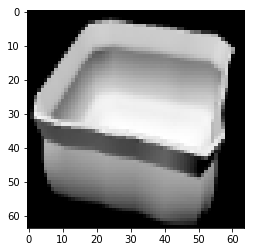

(-1.0, 1.0)

In [165]:
# Preprocessing  
def preprocess(image_name, resize = 64, training_mode = False):
    """
    Crop(conditional), resize, convert to grayscale, detect edge, and return the scaled gradient magnitude
    
    Params:
    image_name: the name of image 
    resize: resize the image
    training_mode: mode control, if True, cropping the bowl images
    
    return: scaled gradient magnitude (shape feature ranged(0,1))
    """
    img = mpimg.imread(image_name)
    # Crop the empty margins for bowl images in training 
    if training_mode and 'bowl' in image_name:
        img = img[80:-80, 50:-50]
    # Resize 
    img = cv2.resize(img, (resize,resize), interpolation=cv2.INTER_LINEAR)
    # convert to GRAY
    if img.shape[-1]==4:  # RGBA to GRAY
        gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    elif img.shape[-1]==3: # RGB to GRAY
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Edge detection with Sobel
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
#     # Get the gradient magnitude
#     sobel = np.sqrt(sobelx**2+sobely**2)
#     return sobel*2/sobel.max()-1
    return gray*2/gray.max()-1

# Test
test_image = '../new_image_files/bowl/png/new200226e0e-9445-4847-86f8-dd9cce24cf15.png'
img = preprocess(test_image, training_mode=True)
plt.imshow(img, cmap='gray')
plt.show()
img.min(), img.max()

In [166]:
# Prepare training data
# Use only bowls
X = []  # store image data 
resize = 64
# Iterate all images for preprocessing
for image_name in bowls:
    try: 
        processed = preprocess(image_name, resize=resize, training_mode=True)
        X.append(processed)
    except:
        print('Discard',image_name, '\n')
# Stack the processed images in array and reshape to trainable format
X = np.stack(X).reshape(-1, resize, resize, 1)
print("In total, there are {} data entries".format(X.shape[0]))

Discard ../new_image_files/bowl/png/new2Liu0a995fe9-3604-4eff-91a8-f58d839476ce.png 

Discard ../new_image_files/bowl/png/new17cf25be7-2605-4bde-9280-91ecb4d46286.png 

Discard ../new_image_files/bowl/png/new0fdc6d30d-ab55-4998-b325-b4d1f095a130.png 

Discard ../new_image_files/bowl/png/new020de0e21-829b-411c-a2e8-1c9a6e7ea342.png 

Discard ../new_image_files/bowl/png/new1845f9071-cc25-46d5-b020-d1a6d5b60806.png 

Discard ../new_image_files/bowl/png/new134202fa7-71cb-49fa-9b55-9c328c32598d.png 

Discard ../new_image_files/bowl/png/new1273ffca5-834b-4db8-ae4d-613b8abeabd6.png 

Discard ../new_image_files/bowl/png/new073feece7-7efa-4cc5-b7b8-7577f848a3c3.png 

Discard ../new_image_files/bowl/png/new0767ce5d0-ec00-40a0-8a33-9fc99450ea8e.png 

Discard ../new_image_files/bowl/png/new1156a5d35-9a7b-492a-93ec-9f42e38b95cd.png 

Discard ../new_image_files/bowl/png/new041063a73-2f24-4f07-a379-87bc1450e69f.png 

Discard ../new_image_files/bowl/png/new12c5e21e7-4289-4c99-a95a-76415e9023f0.png 

D

In [170]:
# Save training data in a pickle file for easy loading
with open('./bowl_traing_data.p', 'wb') as f:
    pickle.dump(X, f)

## Training can start from here
### Load the data from the pickle file

In [2]:
# Load training data from the pickle file
training_data = './bowl_traing_data.p'
X = pickle.load(open(training_data, 'rb'))

In [3]:
# Due to the large size of the data
# Use generator to save memory
def get_batch(batch_size):
    for offset in range(0, len(X), batch_size):
        x_batch = X[offset:offset+batch_size]
        yield x_batch

## Build model 
### Model inputs

In [4]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, lr

### Discriminator
Create a discriminator that discriminates on `images`.  

In [5]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # The first conv layer
        conv_1 = tf.layers.conv2d(images, 16, 5, strides=2, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        conv_1 = tf.maximum(alpha*conv_1, conv_1)   
        # Now the size is 32*32*16
        
        # The second conv layer with batch normalization and leaky relu 
        conv_2 = tf.layers.conv2d(conv_1, 32, 5, strides=2, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(conv_2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # Now the size is  16*16*32
        
        # The third conv layer with batch normalization and leaky relu 
        conv_3 = tf.layers.conv2d(conv_2, 64, 5, strides=2, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(conv_3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # Now the size is 8*8*64
        
        # The fourth conv layer with batch normalization and leaky relu 
        conv_4 = tf.layers.conv2d(relu3, 128, 5, strides=2, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn4 = tf.layers.batch_normalization(conv_4, training=True)
        relu4 = tf.maximum(alpha*bn4, bn4)   
        # Now the size is 4*4*128
        
        # The fifth conv layer with batch normalization and leaky relu 
        conv_5 = tf.layers.conv2d(relu3, 256, 3, strides=2, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn5 = tf.layers.batch_normalization(conv_5, training=True)
        relu5 = tf.maximum(alpha*bn5, bn5)   
        # Now the size is 2*2*256
        
        # Apply dropout
        relu5 = tf.nn.dropout(relu5, keep_prob=0.5)
        
        # Flatten the conv_layer 
        flat = tf.reshape(relu5, [-1,2*2*256])

        # Get the logits and the output
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits) 

    return output, logits


### Generator
Create a `generator` to generate an image using `z`. 

In [6]:
def generator(z, out_channel_dim, is_train=True, keep_prob = 0.5, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        fc = tf.layers.dense(z, 2*2*512)
        
        # Reshape the size for further convlutional layers
        fc = tf.reshape(fc, [-1, 2, 2, 512])
        bn_fc = tf.layers.batch_normalization(fc, training=is_train)
        relu_fc = tf.maximum(alpha*bn_fc, bn_fc)
        # Now the size is 2*2*512
        
        # First conv layer with batch normaization and leaky relu activation
        conv_1 = tf.layers.conv2d_transpose(relu_fc, 256, 3, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(conv_1, training=is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        # Now the size is 4*4*256
        
        # Second conv layer with batch normaization and leaky relu activation
        conv_2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv_2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # Now the size is 8*8*128
        
        # Third conv layer with batch normaization and leaky relu activation
        conv_3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv_3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # Now the size is 16*16*64
        
        # Fourth conv layer with batch normaization and leaky relu activation
        conv_4 = tf.layers.conv2d_transpose(relu3, 32, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(conv_4, training=is_train)
        relu4 = tf.maximum(alpha*bn4, bn4)
        # Now the size is 32*32*32
        
        # Apply dropout 
        relu4 = tf.nn.dropout(relu4, keep_prob=keep_prob)
        
        # Output layer (Fifth conv layer)
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=2, padding='same')
        # Now the size is 64*64*out_channel_dim (1 for Bowl vase gray image)
        
        
        output = tf.tanh(logits)
        
        return output

### Loss

- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Get the generated images
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # Get the logits for both real and fake images
    _, d_logits_real = discriminator(input_real, reuse=False)
    _, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate each loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss

### Optimization
Use Adam optimizer and use **tf.trainable_variables** and filter the variables with names that are in the discriminator and generator scope names.  

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get the whole variables and split into discriminator vars and generator vars
    t_var = tf.trainable_variables()
    d_var = [var for var in t_var if var.name.startswith('discriminator')]
    g_var = [var for var in t_var if var.name.startswith('generator')]
    
    
    # Get training operations for both discriminator and generator
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_var)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_var)
    
    return d_opt, g_opt

##  Training
### Show Output
Show generated bowl images during training

In [9]:
def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    #Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

In [10]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, sample_container):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGBA' else 'gray'  # Original bowl vase images are RGBA, but gray is used here
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, keep_prob=1.0),
        feed_dict={input_z: example_z})
    sample_container.append(samples)
    images_grid = images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

### Train function


In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, sample_container):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("L" for single channel image)
    """
    
    width, height, depth = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
   
    step = 0   # for counting batch numbers
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step+=1   
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                # Run twice generator
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if step%10 == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i+1, epoch_count),
                          'Discriminator loss: {:.3f}...'.format(train_loss_d),
                          'Generator loss: {:.3f}...'.format(train_loss_g))
                if step%100 == 0:
                    show_generator_output(sess, 25, input_z, depth, data_image_mode, sample_container)
    
                

### Training

Epoch 1/10... Discriminator loss: 1.714... Generator loss: 0.856...
Epoch 1/10... Discriminator loss: 1.774... Generator loss: 0.960...
Epoch 1/10... Discriminator loss: 1.463... Generator loss: 0.976...
Epoch 1/10... Discriminator loss: 1.531... Generator loss: 0.923...
Epoch 1/10... Discriminator loss: 1.787... Generator loss: 1.016...
Epoch 1/10... Discriminator loss: 1.472... Generator loss: 0.898...
Epoch 1/10... Discriminator loss: 1.636... Generator loss: 0.897...
Epoch 1/10... Discriminator loss: 1.468... Generator loss: 0.981...
Epoch 1/10... Discriminator loss: 1.379... Generator loss: 0.895...
Epoch 1/10... Discriminator loss: 1.605... Generator loss: 0.741...


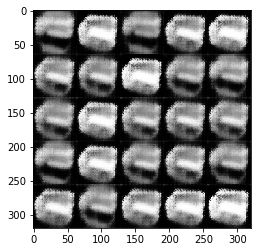

Epoch 1/10... Discriminator loss: 1.316... Generator loss: 1.057...
Epoch 1/10... Discriminator loss: 1.406... Generator loss: 0.970...
Epoch 1/10... Discriminator loss: 1.593... Generator loss: 0.747...
Epoch 1/10... Discriminator loss: 1.441... Generator loss: 0.818...
Epoch 1/10... Discriminator loss: 1.436... Generator loss: 0.793...
Epoch 1/10... Discriminator loss: 1.604... Generator loss: 0.518...
Epoch 1/10... Discriminator loss: 1.334... Generator loss: 0.823...
Epoch 1/10... Discriminator loss: 1.283... Generator loss: 1.060...
Epoch 1/10... Discriminator loss: 1.330... Generator loss: 1.132...
Epoch 1/10... Discriminator loss: 1.292... Generator loss: 0.846...


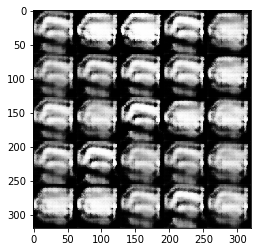

Epoch 1/10... Discriminator loss: 1.154... Generator loss: 1.250...
Epoch 1/10... Discriminator loss: 1.232... Generator loss: 1.134...
Epoch 1/10... Discriminator loss: 1.531... Generator loss: 0.920...
Epoch 1/10... Discriminator loss: 1.417... Generator loss: 1.085...
Epoch 1/10... Discriminator loss: 1.368... Generator loss: 0.986...
Epoch 1/10... Discriminator loss: 1.177... Generator loss: 0.983...
Epoch 2/10... Discriminator loss: 1.156... Generator loss: 1.080...
Epoch 2/10... Discriminator loss: 1.157... Generator loss: 1.039...
Epoch 2/10... Discriminator loss: 1.186... Generator loss: 0.904...
Epoch 2/10... Discriminator loss: 1.162... Generator loss: 1.036...


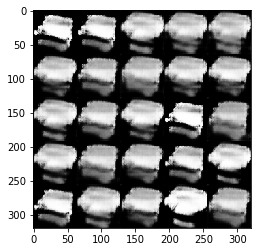

Epoch 2/10... Discriminator loss: 1.330... Generator loss: 0.769...
Epoch 2/10... Discriminator loss: 1.199... Generator loss: 1.080...
Epoch 2/10... Discriminator loss: 1.204... Generator loss: 0.862...
Epoch 2/10... Discriminator loss: 1.217... Generator loss: 1.000...
Epoch 2/10... Discriminator loss: 1.236... Generator loss: 1.226...
Epoch 2/10... Discriminator loss: 1.111... Generator loss: 1.108...
Epoch 2/10... Discriminator loss: 1.215... Generator loss: 0.881...
Epoch 2/10... Discriminator loss: 1.240... Generator loss: 1.005...
Epoch 2/10... Discriminator loss: 1.172... Generator loss: 0.878...
Epoch 2/10... Discriminator loss: 1.258... Generator loss: 0.778...


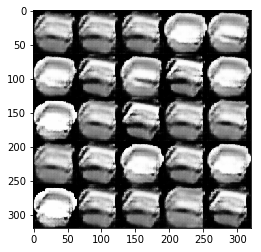

Epoch 2/10... Discriminator loss: 1.192... Generator loss: 2.517...
Epoch 2/10... Discriminator loss: 1.113... Generator loss: 1.193...
Epoch 2/10... Discriminator loss: 1.036... Generator loss: 1.263...
Epoch 2/10... Discriminator loss: 1.003... Generator loss: 1.310...
Epoch 2/10... Discriminator loss: 1.030... Generator loss: 1.126...
Epoch 2/10... Discriminator loss: 0.965... Generator loss: 1.316...
Epoch 2/10... Discriminator loss: 0.956... Generator loss: 1.592...
Epoch 2/10... Discriminator loss: 1.026... Generator loss: 1.153...
Epoch 2/10... Discriminator loss: 1.419... Generator loss: 1.946...
Epoch 2/10... Discriminator loss: 0.949... Generator loss: 1.363...


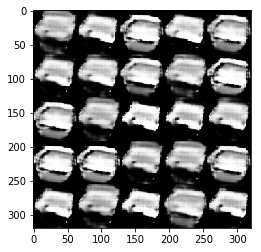

Epoch 2/10... Discriminator loss: 0.855... Generator loss: 1.517...
Epoch 2/10... Discriminator loss: 1.076... Generator loss: 1.189...
Epoch 2/10... Discriminator loss: 1.150... Generator loss: 1.096...
Epoch 3/10... Discriminator loss: 0.956... Generator loss: 1.479...
Epoch 3/10... Discriminator loss: 0.971... Generator loss: 1.263...
Epoch 3/10... Discriminator loss: 1.243... Generator loss: 0.770...
Epoch 3/10... Discriminator loss: 1.018... Generator loss: 1.721...
Epoch 3/10... Discriminator loss: 0.990... Generator loss: 2.180...
Epoch 3/10... Discriminator loss: 1.339... Generator loss: 0.784...
Epoch 3/10... Discriminator loss: 1.222... Generator loss: 1.205...


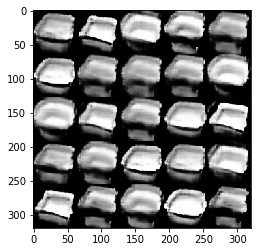

Epoch 3/10... Discriminator loss: 1.428... Generator loss: 0.656...
Epoch 3/10... Discriminator loss: 1.271... Generator loss: 2.329...
Epoch 3/10... Discriminator loss: 1.117... Generator loss: 1.303...
Epoch 3/10... Discriminator loss: 1.096... Generator loss: 0.966...
Epoch 3/10... Discriminator loss: 1.272... Generator loss: 0.994...
Epoch 3/10... Discriminator loss: 1.235... Generator loss: 0.865...
Epoch 3/10... Discriminator loss: 1.142... Generator loss: 1.150...
Epoch 3/10... Discriminator loss: 1.192... Generator loss: 1.507...
Epoch 3/10... Discriminator loss: 1.233... Generator loss: 1.431...
Epoch 3/10... Discriminator loss: 1.281... Generator loss: 1.156...


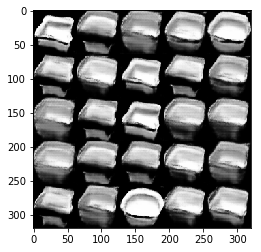

Epoch 3/10... Discriminator loss: 1.362... Generator loss: 0.654...
Epoch 3/10... Discriminator loss: 1.146... Generator loss: 1.571...
Epoch 3/10... Discriminator loss: 1.105... Generator loss: 1.253...
Epoch 3/10... Discriminator loss: 1.096... Generator loss: 1.047...
Epoch 3/10... Discriminator loss: 1.281... Generator loss: 0.654...
Epoch 3/10... Discriminator loss: 1.273... Generator loss: 0.718...
Epoch 3/10... Discriminator loss: 1.300... Generator loss: 1.030...
Epoch 3/10... Discriminator loss: 1.106... Generator loss: 1.072...
Epoch 3/10... Discriminator loss: 1.421... Generator loss: 1.585...
Epoch 3/10... Discriminator loss: 1.128... Generator loss: 0.871...


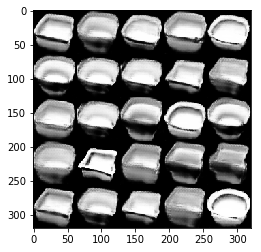

Epoch 4/10... Discriminator loss: 1.208... Generator loss: 1.015...
Epoch 4/10... Discriminator loss: 1.075... Generator loss: 1.181...
Epoch 4/10... Discriminator loss: 1.160... Generator loss: 0.881...
Epoch 4/10... Discriminator loss: 1.140... Generator loss: 1.269...
Epoch 4/10... Discriminator loss: 1.197... Generator loss: 1.492...
Epoch 4/10... Discriminator loss: 1.585... Generator loss: 2.344...
Epoch 4/10... Discriminator loss: 1.056... Generator loss: 1.685...
Epoch 4/10... Discriminator loss: 1.170... Generator loss: 1.594...
Epoch 4/10... Discriminator loss: 1.012... Generator loss: 1.411...
Epoch 4/10... Discriminator loss: 1.030... Generator loss: 1.251...


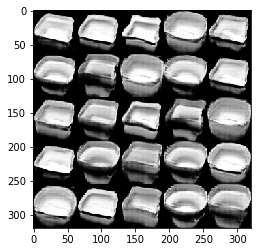

Epoch 4/10... Discriminator loss: 1.493... Generator loss: 1.927...
Epoch 4/10... Discriminator loss: 1.172... Generator loss: 0.823...
Epoch 4/10... Discriminator loss: 1.201... Generator loss: 1.109...
Epoch 4/10... Discriminator loss: 1.049... Generator loss: 1.109...
Epoch 4/10... Discriminator loss: 1.193... Generator loss: 1.552...
Epoch 4/10... Discriminator loss: 1.051... Generator loss: 1.567...
Epoch 4/10... Discriminator loss: 1.073... Generator loss: 1.038...
Epoch 4/10... Discriminator loss: 1.157... Generator loss: 1.943...
Epoch 4/10... Discriminator loss: 1.014... Generator loss: 1.401...
Epoch 4/10... Discriminator loss: 1.120... Generator loss: 1.237...


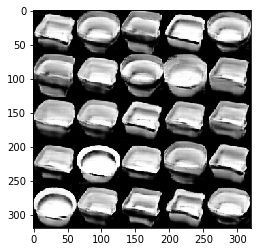

Epoch 4/10... Discriminator loss: 1.230... Generator loss: 2.009...
Epoch 4/10... Discriminator loss: 1.123... Generator loss: 0.930...
Epoch 4/10... Discriminator loss: 0.957... Generator loss: 1.651...
Epoch 4/10... Discriminator loss: 0.953... Generator loss: 1.224...
Epoch 4/10... Discriminator loss: 1.395... Generator loss: 1.207...
Epoch 4/10... Discriminator loss: 1.126... Generator loss: 1.075...
Epoch 4/10... Discriminator loss: 1.046... Generator loss: 0.966...
Epoch 5/10... Discriminator loss: 1.138... Generator loss: 1.318...
Epoch 5/10... Discriminator loss: 1.062... Generator loss: 1.657...
Epoch 5/10... Discriminator loss: 1.312... Generator loss: 0.651...


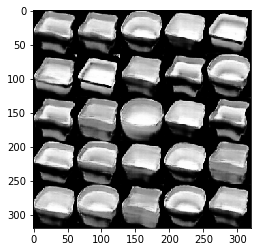

Epoch 5/10... Discriminator loss: 1.189... Generator loss: 0.781...
Epoch 5/10... Discriminator loss: 1.053... Generator loss: 1.124...
Epoch 5/10... Discriminator loss: 1.168... Generator loss: 1.831...
Epoch 5/10... Discriminator loss: 0.910... Generator loss: 1.668...
Epoch 5/10... Discriminator loss: 1.206... Generator loss: 1.586...
Epoch 5/10... Discriminator loss: 1.047... Generator loss: 0.854...
Epoch 5/10... Discriminator loss: 0.883... Generator loss: 1.375...
Epoch 5/10... Discriminator loss: 1.340... Generator loss: 0.898...
Epoch 5/10... Discriminator loss: 0.962... Generator loss: 1.525...
Epoch 5/10... Discriminator loss: 1.581... Generator loss: 0.714...


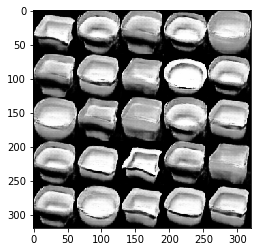

Epoch 5/10... Discriminator loss: 1.153... Generator loss: 1.539...
Epoch 5/10... Discriminator loss: 1.119... Generator loss: 0.836...
Epoch 5/10... Discriminator loss: 1.626... Generator loss: 1.866...
Epoch 5/10... Discriminator loss: 1.013... Generator loss: 1.159...
Epoch 5/10... Discriminator loss: 1.048... Generator loss: 0.912...
Epoch 5/10... Discriminator loss: 1.290... Generator loss: 2.175...
Epoch 5/10... Discriminator loss: 1.016... Generator loss: 1.389...
Epoch 5/10... Discriminator loss: 1.142... Generator loss: 0.784...
Epoch 5/10... Discriminator loss: 1.091... Generator loss: 2.328...
Epoch 5/10... Discriminator loss: 1.045... Generator loss: 0.984...


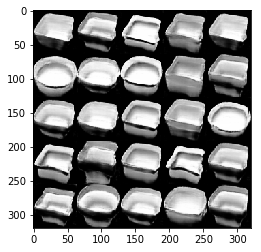

Epoch 5/10... Discriminator loss: 0.882... Generator loss: 1.797...
Epoch 5/10... Discriminator loss: 1.020... Generator loss: 1.057...
Epoch 5/10... Discriminator loss: 0.997... Generator loss: 1.871...
Epoch 5/10... Discriminator loss: 1.514... Generator loss: 0.559...
Epoch 6/10... Discriminator loss: 1.096... Generator loss: 1.193...
Epoch 6/10... Discriminator loss: 0.973... Generator loss: 1.565...
Epoch 6/10... Discriminator loss: 1.250... Generator loss: 1.271...
Epoch 6/10... Discriminator loss: 0.890... Generator loss: 1.438...
Epoch 6/10... Discriminator loss: 1.284... Generator loss: 0.695...
Epoch 6/10... Discriminator loss: 0.847... Generator loss: 1.518...


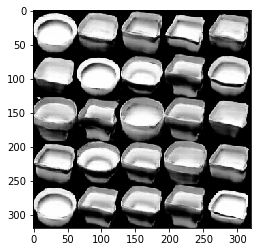

Epoch 6/10... Discriminator loss: 1.037... Generator loss: 1.866...
Epoch 6/10... Discriminator loss: 1.205... Generator loss: 0.791...
Epoch 6/10... Discriminator loss: 0.915... Generator loss: 1.862...
Epoch 6/10... Discriminator loss: 0.912... Generator loss: 1.387...
Epoch 6/10... Discriminator loss: 1.050... Generator loss: 1.510...
Epoch 6/10... Discriminator loss: 0.935... Generator loss: 1.159...
Epoch 6/10... Discriminator loss: 1.044... Generator loss: 1.155...
Epoch 6/10... Discriminator loss: 1.693... Generator loss: 0.390...
Epoch 6/10... Discriminator loss: 0.941... Generator loss: 1.421...
Epoch 6/10... Discriminator loss: 1.336... Generator loss: 0.905...


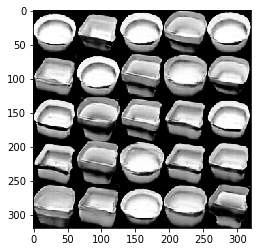

Epoch 6/10... Discriminator loss: 0.891... Generator loss: 1.276...
Epoch 6/10... Discriminator loss: 0.949... Generator loss: 1.067...
Epoch 6/10... Discriminator loss: 1.234... Generator loss: 0.688...
Epoch 6/10... Discriminator loss: 0.965... Generator loss: 1.248...
Epoch 6/10... Discriminator loss: 0.854... Generator loss: 1.445...
Epoch 6/10... Discriminator loss: 0.764... Generator loss: 1.613...
Epoch 6/10... Discriminator loss: 1.126... Generator loss: 2.750...
Epoch 6/10... Discriminator loss: 0.999... Generator loss: 1.835...
Epoch 6/10... Discriminator loss: 0.774... Generator loss: 1.695...
Epoch 6/10... Discriminator loss: 1.409... Generator loss: 3.958...


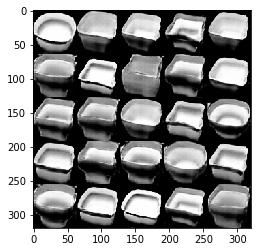

Epoch 6/10... Discriminator loss: 1.464... Generator loss: 1.876...
Epoch 7/10... Discriminator loss: 1.205... Generator loss: 1.256...
Epoch 7/10... Discriminator loss: 0.996... Generator loss: 1.144...
Epoch 7/10... Discriminator loss: 0.850... Generator loss: 1.574...
Epoch 7/10... Discriminator loss: 0.838... Generator loss: 1.888...
Epoch 7/10... Discriminator loss: 1.243... Generator loss: 1.012...
Epoch 7/10... Discriminator loss: 1.214... Generator loss: 0.812...
Epoch 7/10... Discriminator loss: 0.820... Generator loss: 1.477...
Epoch 7/10... Discriminator loss: 0.756... Generator loss: 2.140...
Epoch 7/10... Discriminator loss: 1.012... Generator loss: 0.976...


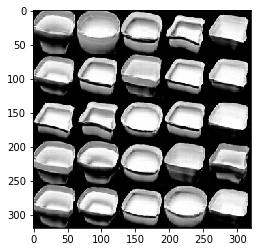

Epoch 7/10... Discriminator loss: 0.797... Generator loss: 1.547...
Epoch 7/10... Discriminator loss: 0.998... Generator loss: 1.018...
Epoch 7/10... Discriminator loss: 0.900... Generator loss: 1.266...
Epoch 7/10... Discriminator loss: 1.039... Generator loss: 0.973...
Epoch 7/10... Discriminator loss: 1.919... Generator loss: 2.493...
Epoch 7/10... Discriminator loss: 1.200... Generator loss: 0.816...
Epoch 7/10... Discriminator loss: 0.829... Generator loss: 1.625...
Epoch 7/10... Discriminator loss: 0.879... Generator loss: 1.252...
Epoch 7/10... Discriminator loss: 1.043... Generator loss: 0.986...
Epoch 7/10... Discriminator loss: 0.757... Generator loss: 1.763...


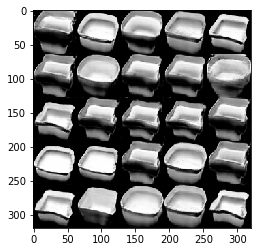

Epoch 7/10... Discriminator loss: 1.732... Generator loss: 0.516...
Epoch 7/10... Discriminator loss: 1.305... Generator loss: 0.926...
Epoch 7/10... Discriminator loss: 0.906... Generator loss: 1.987...
Epoch 7/10... Discriminator loss: 0.913... Generator loss: 1.302...
Epoch 7/10... Discriminator loss: 0.736... Generator loss: 1.813...
Epoch 7/10... Discriminator loss: 1.371... Generator loss: 1.211...
Epoch 7/10... Discriminator loss: 0.882... Generator loss: 1.168...
Epoch 7/10... Discriminator loss: 0.914... Generator loss: 1.436...
Epoch 8/10... Discriminator loss: 0.965... Generator loss: 1.444...
Epoch 8/10... Discriminator loss: 0.988... Generator loss: 1.824...


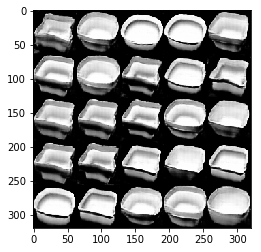

Epoch 8/10... Discriminator loss: 0.759... Generator loss: 1.784...
Epoch 8/10... Discriminator loss: 0.803... Generator loss: 1.583...
Epoch 8/10... Discriminator loss: 0.948... Generator loss: 2.200...
Epoch 8/10... Discriminator loss: 0.679... Generator loss: 2.073...
Epoch 8/10... Discriminator loss: 1.182... Generator loss: 0.827...
Epoch 8/10... Discriminator loss: 0.667... Generator loss: 1.962...
Epoch 8/10... Discriminator loss: 0.559... Generator loss: 2.160...
Epoch 8/10... Discriminator loss: 1.324... Generator loss: 1.213...
Epoch 8/10... Discriminator loss: 1.090... Generator loss: 0.929...
Epoch 8/10... Discriminator loss: 0.806... Generator loss: 1.502...


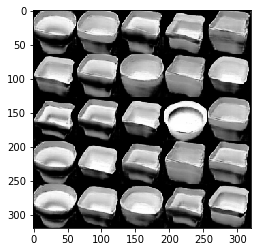

Epoch 8/10... Discriminator loss: 0.710... Generator loss: 2.197...
Epoch 8/10... Discriminator loss: 0.709... Generator loss: 1.874...
Epoch 8/10... Discriminator loss: 0.646... Generator loss: 1.895...
Epoch 8/10... Discriminator loss: 1.873... Generator loss: 4.015...
Epoch 8/10... Discriminator loss: 0.836... Generator loss: 1.523...
Epoch 8/10... Discriminator loss: 0.745... Generator loss: 2.034...
Epoch 8/10... Discriminator loss: 0.968... Generator loss: 1.429...
Epoch 8/10... Discriminator loss: 0.827... Generator loss: 1.398...
Epoch 8/10... Discriminator loss: 0.771... Generator loss: 1.570...
Epoch 8/10... Discriminator loss: 0.648... Generator loss: 2.096...


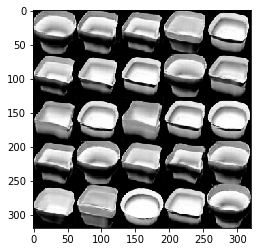

Epoch 8/10... Discriminator loss: 1.382... Generator loss: 1.070...
Epoch 8/10... Discriminator loss: 1.005... Generator loss: 1.444...
Epoch 8/10... Discriminator loss: 0.792... Generator loss: 1.751...
Epoch 8/10... Discriminator loss: 0.703... Generator loss: 1.924...
Epoch 8/10... Discriminator loss: 0.670... Generator loss: 1.742...
Epoch 9/10... Discriminator loss: 0.977... Generator loss: 1.099...
Epoch 9/10... Discriminator loss: 1.364... Generator loss: 0.977...
Epoch 9/10... Discriminator loss: 1.233... Generator loss: 0.913...
Epoch 9/10... Discriminator loss: 0.828... Generator loss: 1.766...
Epoch 9/10... Discriminator loss: 0.686... Generator loss: 2.262...


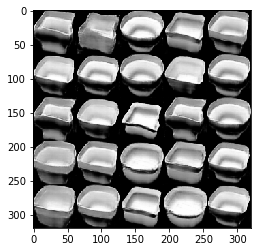

Epoch 9/10... Discriminator loss: 1.243... Generator loss: 1.044...
Epoch 9/10... Discriminator loss: 0.830... Generator loss: 1.349...
Epoch 9/10... Discriminator loss: 0.831... Generator loss: 2.314...
Epoch 9/10... Discriminator loss: 0.884... Generator loss: 2.017...
Epoch 9/10... Discriminator loss: 0.633... Generator loss: 2.430...
Epoch 9/10... Discriminator loss: 1.163... Generator loss: 1.176...
Epoch 9/10... Discriminator loss: 0.758... Generator loss: 1.698...
Epoch 9/10... Discriminator loss: 0.634... Generator loss: 1.985...
Epoch 9/10... Discriminator loss: 0.656... Generator loss: 2.044...
Epoch 9/10... Discriminator loss: 1.179... Generator loss: 1.031...


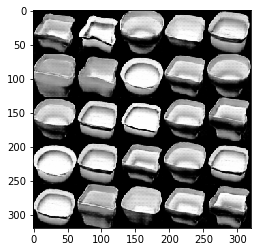

Epoch 9/10... Discriminator loss: 1.032... Generator loss: 1.095...
Epoch 9/10... Discriminator loss: 0.746... Generator loss: 1.566...
Epoch 9/10... Discriminator loss: 0.736... Generator loss: 2.091...
Epoch 9/10... Discriminator loss: 0.625... Generator loss: 2.176...
Epoch 9/10... Discriminator loss: 0.991... Generator loss: 1.080...
Epoch 9/10... Discriminator loss: 0.646... Generator loss: 2.063...
Epoch 9/10... Discriminator loss: 0.975... Generator loss: 1.041...
Epoch 9/10... Discriminator loss: 1.477... Generator loss: 3.993...
Epoch 9/10... Discriminator loss: 1.123... Generator loss: 1.118...
Epoch 9/10... Discriminator loss: 0.695... Generator loss: 2.023...


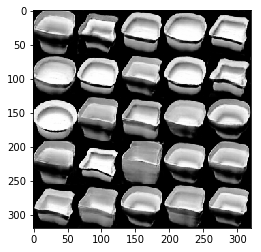

Epoch 9/10... Discriminator loss: 0.669... Generator loss: 2.280...
Epoch 9/10... Discriminator loss: 0.706... Generator loss: 2.996...
Epoch 10/10... Discriminator loss: 1.299... Generator loss: 1.301...
Epoch 10/10... Discriminator loss: 1.254... Generator loss: 0.877...
Epoch 10/10... Discriminator loss: 0.898... Generator loss: 1.868...
Epoch 10/10... Discriminator loss: 0.822... Generator loss: 1.847...
Epoch 10/10... Discriminator loss: 0.840... Generator loss: 1.500...
Epoch 10/10... Discriminator loss: 0.626... Generator loss: 2.285...
Epoch 10/10... Discriminator loss: 0.587... Generator loss: 2.637...
Epoch 10/10... Discriminator loss: 0.604... Generator loss: 3.128...


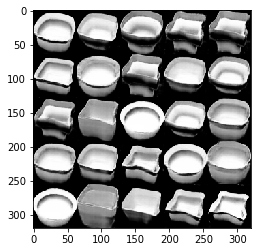

Epoch 10/10... Discriminator loss: 0.658... Generator loss: 2.994...
Epoch 10/10... Discriminator loss: 1.116... Generator loss: 0.946...
Epoch 10/10... Discriminator loss: 0.901... Generator loss: 1.339...
Epoch 10/10... Discriminator loss: 0.797... Generator loss: 1.671...
Epoch 10/10... Discriminator loss: 0.637... Generator loss: 3.051...
Epoch 10/10... Discriminator loss: 0.582... Generator loss: 2.325...
Epoch 10/10... Discriminator loss: 0.732... Generator loss: 1.634...
Epoch 10/10... Discriminator loss: 0.764... Generator loss: 3.570...
Epoch 10/10... Discriminator loss: 0.524... Generator loss: 3.193...
Epoch 10/10... Discriminator loss: 0.474... Generator loss: 3.391...


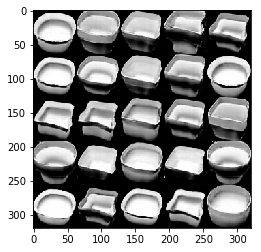

Epoch 10/10... Discriminator loss: 0.472... Generator loss: 2.928...
Epoch 10/10... Discriminator loss: 1.376... Generator loss: 1.263...
Epoch 10/10... Discriminator loss: 1.257... Generator loss: 1.058...
Epoch 10/10... Discriminator loss: 0.935... Generator loss: 2.382...
Epoch 10/10... Discriminator loss: 0.764... Generator loss: 1.466...
Epoch 10/10... Discriminator loss: 0.671... Generator loss: 1.863...
Epoch 10/10... Discriminator loss: 1.089... Generator loss: 0.936...
Epoch 10/10... Discriminator loss: 0.628... Generator loss: 2.164...
Epoch 10/10... Discriminator loss: 0.555... Generator loss: 2.557...


In [12]:
# Params
epochs=10
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta = 0.6
samples_list = []  # Store the generated images after each 100 steps

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta, get_batch, X.shape, 'L', samples_list)

In [34]:
# Save the generated samples to a pickle file
with open('./GAN_generated_samples.p', 'wb') as f:
    pickle.dump(samples_list, f)

## Visualize and compare  
### GAN generated images VS. API generated images

In [48]:
def visualize(samples, show_nbs=25, save_fig=False, fig_name=None):
    """
    samples dim: nbs*height*width
    """
    sample = samples[:show_nbs]  
    fig = plt.figure()
    for i in range(show_nbs):
        fig.add_subplot(np.sqrt(show_nbs), np.sqrt(show_nbs), i+1)
        plt.imshow(sample[i], cmap='gray')
    plt.show()
    if save_fig is True:
        figure_name = 'sample'
        if fig_name is not None:
            figure_name = fig_name
        fig.savefig('./{}.png'.format(figure_name))

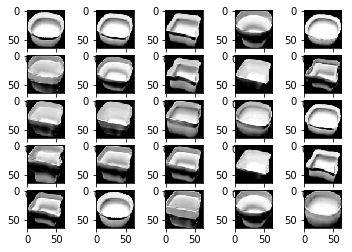

In [49]:
# Visualize the final batch of GAN generated bowls 
GAN_samples = samples_list[-1].squeeze(-1)
visualize(GAN_samples, save_fig=True, fig_name='GAN_samples')

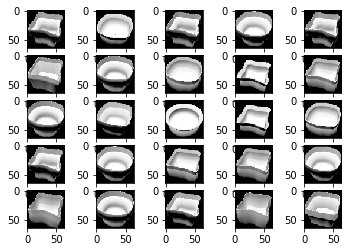

In [50]:
# API generated bowls
API_samples = X.squeeze(-1)
visualize(API_samples, save_fig=True, fig_name='API_samples')